In [1]:
import pandas as pd
import sqlalchemy

# Paramètres de connexion à la base de données SQL Server
server = 'DESKTOP-NTA9A3K'  # Remplace par le vrai nom de ton serveur
database = 'DW_PI7'  # Remplace par le nom de ta base de données
driver = 'ODBC Driver 17 for SQL Server'  # Assure-toi que ce driver est installé

# Création de l'engine SQLAlchemy pour se connecter à la base de données
engine = sqlalchemy.create_engine(f"mssql+pyodbc://{server}/{database}?trusted_connection=yes&driver={driver}")

# Vérifier la connexion et charger les données
with engine.connect() as conn:
    # Charger la table de faits
    query_facts = "SELECT * FROM fact_date2"
    df = pd.read_sql(query_facts, conn)

    # Charger les tables de dimensions
    query_dim_bac = "SELECT * FROM Dim_Bac"
    query_dim_candidat = "SELECT * FROM Dim_Candidat"
    query_dim_gouvernorat = "SELECT * FROM Dim_Gouvernorat"
    query_dim_pays = "SELECT * FROM Dim_Payss"
    query_dim_dossiers = "SELECT * FROM Dim_Dossiers"
    query_dim_diplome = "SELECT * FROM Dim_Diplome"
    query_dim_concour = "SELECT * FROM Dim_Concour"
    query_dim_date = "SELECT * FROM Dim_date"

    dim_bac = pd.read_sql(query_dim_bac, conn)
    dim_candidat = pd.read_sql(query_dim_candidat, conn)
    dim_gouvernorat = pd.read_sql(query_dim_gouvernorat, conn)
    dim_pays = pd.read_sql(query_dim_pays, conn)
    dim_dossiers = pd.read_sql(query_dim_dossiers, conn)
    dim_diplome= pd.read_sql(query_dim_diplome, conn)
    dim_concour = pd.read_sql(query_dim_concour, conn)
    dim_date = pd.read_sql(query_dim_date, conn)


# Vérification des données fusionnées
print(df.head())
 



   Candidature_Pk  Dossier_Pk  Candidat_pk  Gouv_PK  Pays_Pk  Diplome_Pk  \
0             113        1773          113       17       32           0   
1             125        1936          125        7       32           0   
2             169         169          169       13       32           0   
3             258         258          258       10       32           0   
4             302         302          302       16       32           0   

   Concours_Pk  Bac_Pk  Date_Pk1  Date_Pk2  Date_Pk3  Date_Pk4  Date_Pk5  \
0           39       2  20220724  20230808  20230811  20230815  20220812   
1           41       3  20220722  20210814  20210801  20210805  20220726   
2           43       1  20220721  20210806  20210811  20210815  20220706   
3           37       6  20220717  20220811  20230801  20230805  20220709   
4           43      10  20220717  20210806  20210811  20210815  20220806   

   score_final  moy_bac_et  Admission  
0        95.35       14.50          0  
1     

In [17]:
df_merged = df.merge(dim_bac, on='Bac_Pk', how='left')
df_merged = df_merged.merge(dim_diplome, on='Diplome_Pk', how='left')

In [21]:
print(df_merged.columns.tolist())


['Candidature_Pk', 'Dossier_Pk', 'Candidat_pk', 'Gouv_PK', 'Pays_Pk', 'Diplome_Pk', 'Concours_Pk', 'Bac_Pk', 'Date_Pk1', 'Date_Pk2', 'Date_Pk3', 'Date_Pk4', 'Date_Pk5', 'score_final', 'moy_bac_et', 'Admission', 'nature_bac_x', 'Mention_x', 'nature_bac_encoded', 'Mention_encoded', 'nature_bac_y', 'bac', 'Mention_y', 'Diplome', 'Faculte', 'annee_souhaite', 'Cin', 'Specialite']


In [23]:
df_merged = df_merged.rename(columns={'Mention_x': 'Mention', 'nature_bac_x': 'nature_bac'})


In [25]:
features = ['score_final', 'moy_bac_et', 'Mention', 'nature_bac']
df_final = df_merged[features].copy()

In [27]:
df_final.dropna(inplace=True)  # Supprimer les lignes avec valeurs manquantes

In [43]:
df_final['classe_internationale'] = ((df_final['score_final'] > 80) & 
                                    (df_final['moy_bac_et'] > 14)).astype(int)

In [45]:
print(df_final['classe_internationale'].value_counts())

classe_internationale
0    64
1    11
Name: count, dtype: int64


In [49]:
mention_order = ['مقبول', 'جيد', 'جيد جدا', 'ممتاز']  # Du plus bas au plus haut

# Transformer directement la colonne 'Mention' en Categorical avec un ordre
df_final['Mention'] = pd.Categorical(df_final['Mention'], categories=mention_order, ordered=True)

# Puis récupérer les codes associés
df_final['Mention_code'] = df_final['Mention'].cat.codes


In [51]:
df_final = pd.get_dummies(df_final, columns=['nature_bac'], prefix='bac')

In [53]:
from sklearn.model_selection import train_test_split

X = df_final[['score_final', 'moy_bac_et', 'Mention_code'] + 
             [col for col in df_final.columns if col.startswith('bac_')]]
y = df_final['classe_internationale']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [55]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_cols = ['score_final', 'moy_bac_et', 'Mention_code']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(max_depth=3),
    "Random Forest": RandomForestClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"--- {name} ---")
    print(classification_report(y_test, y_pred))

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.95      0.90      0.92        20
           1       0.50      0.67      0.57         3

    accuracy                           0.87        23
   macro avg       0.72      0.78      0.75        23
weighted avg       0.89      0.87      0.88        23

--- Decision Tree ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00         3

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.67      0.80         3

    accuracy                           0.96        23
   macro avg       0.98      0.83      0.89        23
we

In [61]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.67      0.80         3

    accuracy                           0.96        23
   macro avg       0.98      0.83      0.89        23
weighted avg       0.96      0.96      0.95        23

AUC: 0.98


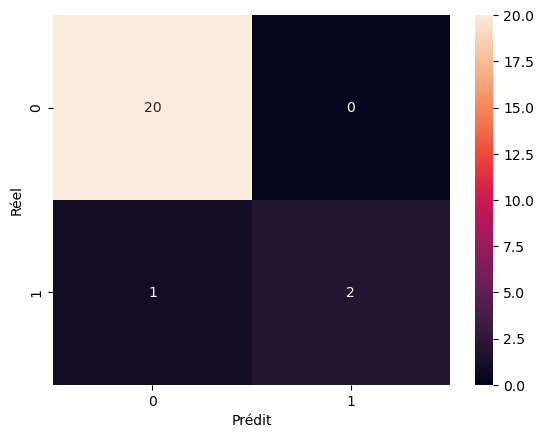

In [65]:
from sklearn.metrics import confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt


y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Matrice de confusion
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.xlabel('Prédit')
plt.ylabel('Réel')

# Rapport de classification
print(classification_report(y_test, y_pred))

# AUC-ROC
print(f"AUC: {roc_auc_score(y_test, y_proba):.2f}")

In [89]:
import os
import joblib
import json

# Créer le dossier s'il n'existe pas
os.makedirs('modeles', exist_ok=True)

# Sauvegarder le modèle et le scaler
joblib.dump(best_model, 'modeles/classe_internationale_model.pkl')
joblib.dump(scaler, 'modeles/scaler.pkl')

# Sauvegarder les métadonnées
metadata = {
    'features': list(X.columns),
    'mention_mapping': {i: cat for i, cat in enumerate(mention_order)},
    'bac_columns': [col for col in df_final.columns if col.startswith('bac_')]
}

with open('modeles/metadata.json', 'w') as f:
    json.dump(metadata, f)

In [91]:
print("Contenu du dossier 'modeles':")
print(os.listdir('modeles'))

Contenu du dossier 'modeles':
['classe_internationale_model.pkl', 'metadata.json', 'scaler.pkl']
